<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch_%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch : Tutorial 初級 : 転移学習チュートリアル

http://torch.classcat.com/2018/04/29/pytorch-tutorial-transfer-learning/


In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

#ukiyoeから
import matplotlib.pyplot as plt

plt.ion()   # interactive mode

#Google driveのデータをマウント

In [5]:

'''
－－－－－－－－－－－－－－
アップデータするデータの構造
Advanced.zip ----data---- hymenoptera_data----train
                         |            |    |--val
                         |            |-- imagenet_class_index.json
                         |            |-- __init__.py
                         |            |-- bennetts-wallabu-01.jpg
                         |            |-- goldenretriever-3724972_640.jpg
                         |
                         |-- utils---- __pycache__---- __init__.cpython-36.pyc
                                       |                        |-- dataloader_image_classification.cpython-36.pyc
                                       |-- __init__.py
                                       |-- dataloader_image_classification.py
－－－－－－－－－－－－－－
'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

#Advanced.zipを解凍

!date -R
!unzip -qq drive/My\ Drive/Advanced.zip
!date -R
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fri, 29 Nov 2019 02:42:42 +0000
replace data/__init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/bennetts-wallaby-01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/goldenretriever-3724972_640.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
n
replace data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg? [y]es, [n]o, [A]

#データをロードする
データをロードするために torchvision と torch.utils.data パッケージを使用します。今日解いていく問題はアリ (= ants) とハチ (= bees) を分類するモデルを訓練することです。アリとハチのためにおよそ 120 訓練画像を持ちます。各クラスのために 75 検証画像があります。通常は、スクラッチから訓練される場合、これは一般化するには非常に小さいデータセットです。私達は転移学習を使用していますので、合理的に上手く一般化することができるはずです。

このデータセットは imagenet の非常に小さなサブセットです。

In [0]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#少数の画像を可視化する

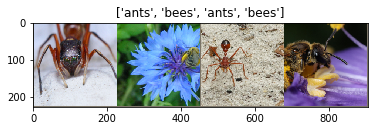

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#モデルを訓練する
さて、モデルを訓練するための一般的な関数を書きましょう。ここで、次を示します :

学習率をスケジューリングする
ベスト・モデルをセーブする
以下で、パラメータ scheduler は torch.optim.lr_scheduler からの LR scheduler オブジェクトです。

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#モデル予測を可視化する
少数の画像のための予測を表示するための一般的な関数。

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#convnet を再調整する
事前訓練されたモデルをロードして最後の完全結合層をリセットします。

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 360MB/s]


#訓練と評価
CPU 上でおよそ 15-25 分かかるはずです。けれども GPU 上なら、1 分もかかりません。

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5026 Acc: 0.7418
val Loss: 0.2908 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.3515 Acc: 0.8730
val Loss: 0.2584 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4021 Acc: 0.8238
val Loss: 0.2127 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4904 Acc: 0.7992
val Loss: 0.4650 Acc: 0.8235

Epoch 4/24
----------
train Loss: 0.3453 Acc: 0.8607
val Loss: 1.1767 Acc: 0.7059

Epoch 5/24
----------
train Loss: 0.3320 Acc: 0.8975
val Loss: 0.3740 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.3562 Acc: 0.8648
val Loss: 0.2950 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.1671 Acc: 0.9262
val Loss: 0.2364 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2697 Acc: 0.8893
val Loss: 0.2063 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.1664 Acc: 0.9262
val Loss: 0.2083 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2194 Acc: 0.9180
val Loss: 0.1921 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2959 Acc: 0.8811
val Loss: 0.2306 Acc: 0.9412

Epoch 12/24
----------
t

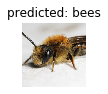

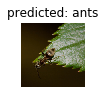

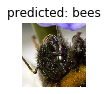

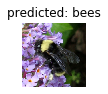

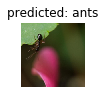

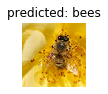

In [14]:
visualize_model(model_ft)

#固定された特徴抽出器としての ConvNet
ここで、最終層を除くネットワーク総てを凍結する必要があります。勾配が backward() で計算されないようにパラメータを凍結するために requires_grad == False を設定する必要があります。

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#訓練と評価
これは CPU 上で前のシナリオに比べておよそ半分の時間で済むでしょう。ネットワークの殆どに対して勾配が計算される必要がないためです。けれども、forward は計算される必要があります。

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4899 Acc: 0.7336
val Loss: 0.2642 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.3832 Acc: 0.8320
val Loss: 0.2498 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4173 Acc: 0.8033
val Loss: 0.1763 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4932 Acc: 0.8033
val Loss: 0.1709 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4254 Acc: 0.8115
val Loss: 0.2562 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4058 Acc: 0.8443
val Loss: 0.1714 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.2911 Acc: 0.8852
val Loss: 0.1857 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.2615 Acc: 0.8934
val Loss: 0.1929 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2927 Acc: 0.8730
val Loss: 0.1935 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3250 Acc: 0.8648
val Loss: 0.2028 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2815 Acc: 0.8689
val Loss: 0.1892 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3583 Acc: 0.8648
val Loss: 0.2307 Acc: 0.9216

Epoch 12/24
----------
t

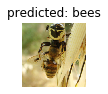

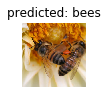

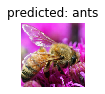

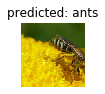

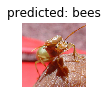

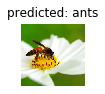

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()